In [1]:
import os
import numpy as np
import torch as tr

from glob import glob as glob
import pandas as pd

from CSWSEM import *

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')

### load gridsearch files

In [2]:
hdf = pd.read_csv('gsdata/humandf.csv')
humanB = hdf.loc[:,'blocked mean']
humanI = hdf.loc[:,'interleaved mean']

In [3]:
gsname = 'gs2'
lrL = [0.01, 0.05, 0.1]
alfaL = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
lmdaL = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

In [19]:
""" load gridsearch files
"""
def make_gsdf(gsname,save=False,debug=False):
  gs_dir = "gsdata/%s/"%gsname
  fpathL = glob(gs_dir+'*')
  df_L = []
  ### initialize gsdf
  if debug: fpathL = fpathL[:20]
  for fpath in fpathL:
    batch_df = pd.read_csv(fpath)
    df_L.append(batch_df)
  gsdf = pd.concat(df_L)
  ### gsdf manipulations
  gsdf.index = np.arange(len(gsdf))
  gsdf = gsdf.drop(columns=['Unnamed: 0','like','prior'])
  gsdf.loc[:,'accuracy'] = 1-gsdf.loc[:,'loss']
  gsdf.loc[(gsdf.trial>=160),'phase'] = 'test'
  gsdf.loc[(gsdf.trial<160),'phase'] = 'train'
  gsdf.loc[:,'period'] = gsdf.trial//40
  if save:
    gsdf.to_csv('gsdata/%s.csv'%gsname)
    print('saved %s.csv'%gsname)
  return gsdf

In [20]:
## load
debug = 0 # debug
if debug:
  gsdf = make_gsdf(gsname,save=0,debug=debug)
else:
#   gsdf = make_gsdf(gsname,save=1,debug=0)
  gsdf = pd.read_csv('gsdata/%s.csv'%gsname)
print('max delta_time',gsdf.delta_time.max())

saved gs2.csv
max delta_time 66.4222927093506


### structure data for analyis

In [41]:
def build_dataD(gsdf,metric='accuracy',verb=True):
  """ [seed,time] per model_param and condition (mp,c)
  extracts and reformats a column of gsdf
  D[model+param_str][cond] = [seed,time]
  """
  paramL = ['learn_rate','alfa','lmda']
  dataD = {}
  ntrials = (gsdf.trial.max() - gsdf.trial.min()) + 1
  for nosplit,m_df in gsdf.groupby(['nosplit']):  
    if nosplit: model='LSTM'
    else: model='SEM'
    for p,p_df in m_df.groupby(paramL):
      param_str = "-".join([str(p_i) for p_i in p])
      dataD_key = "%s-%s"%(model,param_str)
      dataD[dataD_key] = {}
      for cond,c_df in p_df.groupby('condition'):
        if verb: print(model,param_str,cond)
        sgroup = c_df.groupby('seed')
        seed_arr = -np.ones([len(sgroup),ntrials])
        for s_idx,(s,s_df) in enumerate(sgroup):
          seed_arr[s_idx] = s_df.loc[:,metric]
        dataD[dataD_key][cond] = seed_arr
  return dataD


from sklearn.metrics import adjusted_rand_score
def build_summary_df(gsdf):
  """ metrics on model-param (mp) level
  """
  accD = build_dataD(gsdf,metric='accuracy',verb=0)
  schD = build_dataD(gsdf,metric='active_schema',verb=0)
  curD = build_dataD(gsdf,metric='curriculum',verb=0)
  assert accD.keys()==schD.keys()==curD.keys()

  L = []
  for param_str in accD.keys():
    mod,lr,alfa,lmda = param_str.split('-')
    for cond in ['blocked','interleaved']:
      acc_ar = accD[param_str][cond]
      sch_ar = schD[param_str][cond].astype(int)
      cur_ar = curD[param_str][cond].astype(int)
      ## mse
      semM = acc_ar.mean(0)
      if len(semM)==40: # test phase only
        t0=160
      else: t0=0
      humanM = hdf.loc[t0:,'%s mean'%cond]
      mse = np.mean((semM-humanM)**2)
      ## adjusted rand
      # calculate AR for each seed
      # mean over seeds
      ar = np.mean([
        adjusted_rand_score(cur_ar[i],sch_ar[i]
          ) for i in range(len(cur_ar))]
      )
      # num schemas
      num_schemas = np.mean(sch_ar.max(1))
      ## collect
      L.append({
        'model':mod,
        'cond':cond,
        'lr':float(lr),
        'alfa':float(alfa),
        'lmda':float(lmda),
        'mse':float(mse),
        'carving':float(ar),
        'num_schemas':num_schemas,
        'test_acc':np.mean(semM[-40:])
      })
  return pd.DataFrame(L)    


In [42]:
smdf = build_summary_df(gsdf)

In [100]:
for mod in ['LSTM','SEM']:
  smdf_ = smdf[(smdf.model == mod)]
  smdf_g = smdf_.groupby(['lr','alfa','lmda'])
  for pstr_tup,smd in smdf_g:
    acc_diff = smd.test_acc.diff().iloc[-1]*-100
    ax = plt.gca()
    smd.plot.bar('cond','test_acc',
                 ax=ax,
                 ylim=(0.5,1),
                 title='acc_diff = %f'%acc_diff
                )
    ax.set_xticklabels(['B','I'])
    pstr = "%s__diff%f_lr%falfa%flmda%f.png"%(mod,acc_diff,*pstr_tup)
    plt.savefig('figures/gs2/test_acc/'+pstr)
    plt.close('all')

### analysis of test acc

In [39]:
smdf_test = build_summary_df(gsdf[gsdf.phase == 'test'])
smdf_test

,model,cond,lr,alfa,lmda,mse,carving,num_schemas
0,SEM,blocked,0.01,0.01,0.01,0.001807,0.507469,12.372549
1,SEM,interleaved,0.01,0.01,0.01,0.065550,0.230927,10.156863
2,SEM,blocked,0.01,0.01,0.10,0.001807,0.507469,12.372549
3,SEM,interleaved,0.01,0.01,0.10,0.065550,0.230927,10.156863
4,SEM,blocked,0.01,0.01,1.00,0.001807,0.507469,12.372549
...,...,...,...,...,...,...,...,...
763,LSTM,interleaved,0.10,100000.00,1000.00,0.027529,0.000000,0.000000
764,LSTM,blocked,0.10,100000.00,10000.00,0.055161,0.000000,0.000000
765,LSTM,interleaved,0.10,100000.00,10000.00,0.027529,0.000000,0.000000
766,LSTM,blocked,0.10,100000.00,100000.00,0.055161,0.000000,0.000000


# scatter summary metric df


<Figure size 432x288 with 0 Axes>

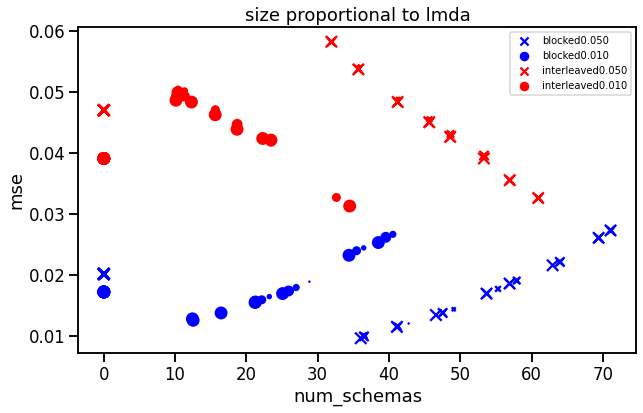

In [149]:
plt.figure()

xvar='num_schemas'
yvar='mse'

colorL = ['b','r']
f,ax = plt.subplots(1,1,figsize=(10,6))
for i,c in enumerate(['blocked','interleaved']):
  for j,l in enumerate([0.05,0.01]):
    sdf = smdf[(smdf.cond==c)&(smdf.lr==l)]
    ax.scatter(sdf.loc[:,xvar],sdf.loc[:,yvar],
                c=colorL[i],marker=['x','o'][j],
                label="%s%.3f"%(c,l),
               s=(np.log10(sdf.alfa)+2)**(2.5)
               )
    ax.set_title('size proportional to alfa')
ax.set_xlabel(xvar)
ax.set_ylabel(yvar)
# ax.set_ylim(0,0.06)
plt.legend(fontsize=10)
# plt.savefig('figures/gs2/scatter3-%s-%s'%(xvar,yvar))

# different way of making smdf

In [59]:

from sklearn.metrics import adjusted_rand_score
def build_summary_df2(gsdf):
  """ metrics on model-param (mp) level
  """
  accD = build_dataD(gsdf,metric='accuracy',verb=0)
  schD = build_dataD(gsdf,metric='active_schema',verb=0)
  curD = build_dataD(gsdf,metric='curriculum',verb=0)
  assert accD.keys()==schD.keys()==curD.keys()

  L = []
  for param_str in accD.keys():
    mod,lr,alfa,lmda = param_str.split('-')
    if mod=='LSTM':continue
    D = {
        'model':mod,
        'lr':float(lr),
        'alfa':float(alfa),
        'lmda':float(lmda)
        }
    for cond in ['blocked','interleaved']:
      acc_ar = accD[param_str][cond]
      sch_ar = schD[param_str][cond].astype(int)
      cur_ar = curD[param_str][cond].astype(int)
      ## mse
      semM = acc_ar.mean(0)
      humanM = hdf.loc[:,'%s mean'%cond]
      mse = np.mean((semM-humanM)**2)
      ## adjusted rand
      # calculate AR for each seed
      # mean over seeds
      ar = np.mean([
        adjusted_rand_score(cur_ar[i],sch_ar[i]
          ) for i in range(len(cur_ar))]
      )
      # num schemas
      num_schemas = np.mean(sch_ar.max(1))
      ## collect
      D.update({
        'mse-%s'%cond:float(mse),
        'carving-%s'%cond:float(ar),
        'num_schemas-%s'%cond:num_schemas
      })
    L.append(D)
  return pd.DataFrame(L)    


In [60]:
smdf2 = build_summary_df2(gsdf)

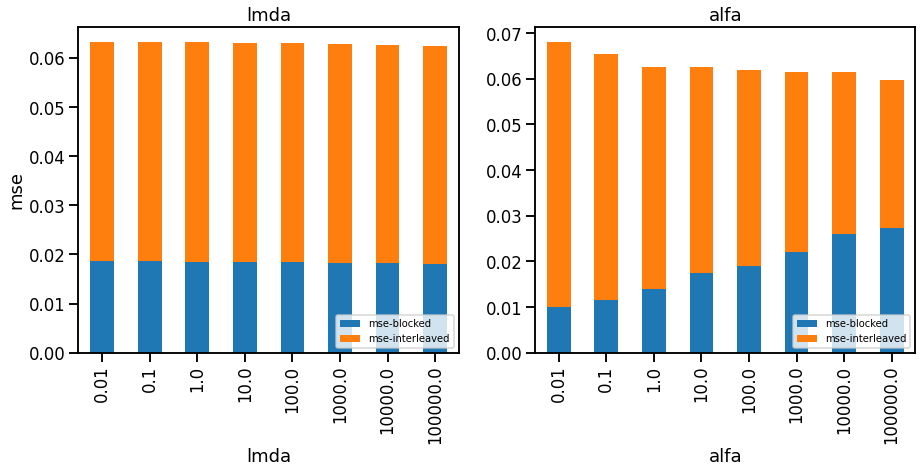

In [130]:
metric= 'mse'
f,axar = plt.subplots(1,2,figsize=(15,6))
smdfplt = smdf2[smdf2.lr==0.05
               ].loc[:,['alfa','lmda','%s-blocked'%metric,'%s-interleaved'%metric]]

smdfplt.groupby(['lmda']).mean().drop('alfa',axis=1
            ).plot.bar(stacked=True,ax=axar[0],title='lmda')
smdfplt.groupby(['alfa']).mean().drop('lmda',axis=1
            ).plot.bar(stacked=True,ax=axar[1],title='alfa')
for ax in axar:
  ax.legend(loc=4,fontsize=10)
#   ax.set_ylim(.3,.4)
#   ax.set_ylim(.6,.7)
#   ax.set_ylim(.6,.7)
axar[0].set_ylabel('%s'%metric)
plt.savefig('figures/gs2/bar-%s-alfa-lmda'%metric)

<AxesSubplot:xlabel='carving-blocked', ylabel='mse-blocked'>

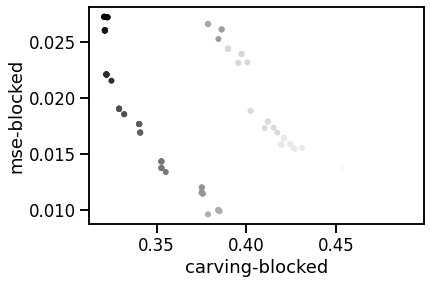

In [326]:
sdfplt = smdf2[smdf2.loc[:,'mse-blocked']<.1]
sdfplt.plot.scatter('carving-blocked','mse-blocked',
#                    c=np.log10(smdf2.alfa)
                   c=sdfplt.loc[:,'num_schemas-interleaved']
                  )
# smdf2.plot.scatter?



# accuracy plots 

In [ ]:
def plt_acc_(ax,acc_arr,tag=None):
  Nseeds,_ = acc_arr.shape
  for acc_seed in acc_arr:
    ax.plot(acc_seed,lw=.05,c='k')
  M = acc_arr.mean(0)
  S = acc_arr.std(0)/np.sqrt(Nseeds)
  ax.fill_between(range(200),M-S,M+S,alpha=.5,color='b')
  ax.plot(M,lw=3,c='b')
  ax.set_ylim(0.2,1)
  return None

def plt_acc(cond_dict,mse_dict,title):
  f,ax = plt.subplots(2,1,figsize=(8,4),sharex=True)
  for idx,(cond,arr) in enumerate(cond_dict.items()):
    plt_acc_(ax[idx],arr)
    ax[idx].plot(hdf.loc[:,"%s mean"%cond],color='red',lw=3)
    ax[idx].set_title("%s mse%f"%(title,mse_dict[cond]))
  total_mse = np.sum([i for i in mse_dict.values()])
  plt.savefig('figures/%s/acc/mse%.4f-acc-%s.png'%(gsname,total_mse,title))
  plt.close('all')
  
def calc_mse(acc_cond_dict):
  """ depr """
  D = {}
  for cond,acc_arr in acc_cond_dict.items():
    semM = acc_arr.mean(0)
    humanM = hdf.loc[:,'%s mean'%cond]
    D[cond] = np.mean((semM-humanM)**2)
  return D

In [ ]:
accD = build_dataD(gsdf,metric='accuracy',verb=False)
print('num model conditions',len(accD))
L = []
for model_param,cond_dict in accD.items():
  mse = calc_mse(cond_dict)
  title = model_param
  mse = calc_mse(cond_dict)
  print(model_param,mse)
  L.append({'model':model_param,'mse':mse})
#   plt_acc(cond_dict,mse,title)

# param space

### plot param heatmap
- update with summary metric dataframe

In [ ]:
#### outdated
# make_mse_df(accD)
# msedf_ = make_mse_df(accD)
#### use
# build_summary_df(gsdf)


In [ ]:
f,axar = plt.subplots(3,2,figsize=(25,20),sharex=True,sharey=True)

for c_i,c in enumerate(['blocked','interleaved']):
  msedf = msedf_[(msedf_.model=='SEM')&(msedf_.cond==c)]
  for lr_i,lr in enumerate(lrL):
    
    ## MAKE ARR
    arr = -np.ones([len(alfaL),len(lmdaL)])
    for a_i,alfa in enumerate(alfaL):
      for lm_i,lmda in enumerate(lmdaL):
        lr_bool = (msedf.lr == lr)
        a_bool = (msedf.alfa == alfa)
        lm_bool = (msedf.lmda == lmda)
        m = msedf[lr_bool&a_bool&lm_bool].mse.values
        if len(m):
          arr[a_i,lm_i]=m

    ## PLOT
    ax = axar[lr_i,c_i]
    ax.set_title('%s lr=%.2f'%(c,lr))
    sns.heatmap(arr,ax=ax,annot=arr.round(2),vmax=0.05)
  ax.set_xlabel('alfaL')
  ax.set_ylabel('lmdaL')

plt.savefig('figures/%s/mseheat'%gsname)

In [ ]:
assert False

# schema inference analysis


In [ ]:
sdf = build_summary_df(gsdf)
sdf.sort_values('carving',ascending=0)

In [ ]:
currD = build_dataD(gsdf,metric='curriculum',verb=False)
schD = build_dataD(gsdf,metric='active_schema',verb=False)
k_ = list(schD.keys())[0]

In [ ]:
cond = 'blocked'
curr_arr = curr_D[k_][cond]
actsch_arr = actsch_D[k_][cond]

actsch_arr
curr_arr.shape